<a href="https://colab.research.google.com/github/202511040-dev/202511040_Vatsal-_Patel/blob/main/202511040_DL_LAB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import pandas as pd
import numpy as np
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D


In [69]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [65]:
file_path = "/content/drive/My Drive/DL/data.csv"

# Skip the empty first row
df = pd.read_csv(file_path, skiprows=1)

# Clean column names
df.columns = df.columns.str.strip()

df.head()


,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [66]:
# Remove missing rows
df = df.dropna()

# Clean label column
df['label'] = df['label'].astype(str).str.strip()

# Map labels:
# OR = Original Review (Genuine → 0)
# CG = Computer Generated (Fake → 1)
df['label'] = df['label'].map({
    'OR': 0,
    'CG': 1
})

# Remove any unmapped rows (safety)
df = df.dropna(subset=['label'])

df['label'].value_counts()


,count
label,
1,20216
0,20216


In [67]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)

    tokens = [
        word for word in tokens
        if word not in string.punctuation and word not in stop_words
    ]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)


In [70]:
df['clean_review'] = df['text_'].apply(preprocess_text)

df[['text_', 'clean_review']].head()


,text_,clean_review
0,"Love this! Well made, sturdy, and very comfor...",love well made sturdy comfortable love pretty
1,"love it, a great upgrade from the original. I...",love great upgrade original 've mine couple year
2,This pillow saved my back. I love the look and...,pillow saved back love look feel pillow
3,"Missing information on how to use it, but it i...",missing information use great product price
4,Very nice set. Good quality. We have had the s...,nice set good quality set two month


In [79]:
X = df['clean_review']

vectorizer = TfidfVectorizer(
    max_features=5000
)

X_tfidf = vectorizer.fit_transform(X)


In [73]:
VOCAB_SIZE = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])

sequences = tokenizer.texts_to_sequences(df['clean_review'])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


In [75]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_category = label_encoder.fit_transform(df['category'])

num_classes = len(np.unique(y_category))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_category,
    test_size=0.2,
    random_state=42,
    stratify=y_category
)


In [84]:
from tensorflow.keras.layers import Input

category_model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(VOCAB_SIZE, 128),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

category_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
category_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,802 (4.95 MB)

 Trainable params: 1,297,802 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
category_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.1535 - loss: 2.2062 - val_accuracy: 0.4408 - val_loss: 1.6113
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.4179 - loss: 1.5220 - val_accuracy: 0.5521 - val_loss: 1.2811
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5741 - loss: 1.1280 - val_accuracy: 0.6563 - val_loss: 0.9875
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6414 - loss: 0.9668 - val_accuracy: 0.6563 - val_loss: 0.9811
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6822 - loss: 0.8840 - val_accuracy: 0.6674 - val_loss: 0.9000
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7092 - loss: 0.8155 - val_accuracy: 0.6998 - val_loss: 0.8529
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7323 - loss: 0.7486 - val_accuracy: 0.7073 - val_loss: 0.7943
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7509 - loss: 0.7045 - 

# Task:1

In [86]:
y_pred = np.argmax(category_model.predict(X_test), axis=1)

print("Product Category Classification Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Product Category Classification Results
Accuracy: 0.6997650550265859
                              precision    recall  f1-score   support

                     Books_5       0.64      0.82      0.72       874
Clothing_Shoes_and_Jewelry_5       0.91      0.52      0.66       770
               Electronics_5       0.57      0.86      0.68       798
          Home_and_Kitchen_5       0.71      0.51      0.59       811
              Kindle_Store_5       0.85      0.58      0.69       946
             Movies_and_TV_5       0.96      0.79      0.87       717
              Pet_Supplies_5       0.81      0.88      0.84       851
       Sports_and_Outdoors_5       0.46      0.68      0.55       789
Tools_and_Home_Improvement_5       0.63      0.72      0.67       772
            Toys_and_Games_5       0.93      0.63      0.75       759

                    accuracy                           0.70      8087
                   macro avg       0.75      0.7

In [87]:
y_fake = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_fake,
    test_size=0.2,
    random_state=42,
    stratify=y_fake
)


In [89]:
from tensorflow.keras.layers import Input

fake_model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(VOCAB_SIZE, 128),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

fake_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

fake_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,288,321 (4.91 MB)

 Trainable params: 1,288,321 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
fake_model.fit(
    X_train,
    y_train,
    epochs=8,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6163 - loss: 0.6293 - val_accuracy: 0.7357 - val_loss: 0.4670
Epoch 2/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8024 - loss: 0.4046 - val_accuracy: 0.8442 - val_loss: 0.3403
Epoch 3/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8368 - loss: 0.3473 - val_accuracy: 0.8584 - val_loss: 0.3070
Epoch 4/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8631 - loss: 0.3062 - val_accuracy: 0.7604 - val_loss: 0.4500
Epoch 5/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8577 - loss: 0.3065 - val_accuracy: 0.8393 - val_loss: 0.3307
Epoch 6/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8792 - loss: 0.2746 - val_accuracy: 0.8742 - val_loss: 0.2843
Epoch 7/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8790 - loss: 0.2689 - val_accuracy: 0.8495 - val_loss: 0.3197
Epoch 8/8
455/455 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8849 - loss: 0.2650 - val_accu

# Task:2

In [91]:
y_pred = (fake_model.predict(X_test) > 0.5).astype(int)

print("Fake Review Detection Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fake Review Detection Results
Accuracy: 0.8936564857178187
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4044
           1       0.89      0.89      0.89      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



In [94]:

fake_reviews_df = df[df['label'] == 1]

fake_count_per_category = fake_reviews_df['category'].value_counts()

max_fake_category = fake_count_per_category.idxmax()
max_fake_count = fake_count_per_category.max()

print("Fake reviews count per category:")
print(fake_count_per_category)
print("\nCategory with maximum fake reviews:", max_fake_category)
print("Number of fake reviews:", max_fake_count)


Fake reviews count per category:
category
Kindle_Store_5                  2365
Books_5                         2185
Pet_Supplies_5                  2127
Home_and_Kitchen_5              2028
Electronics_5                   1994
Sports_and_Outdoors_5           1973
Tools_and_Home_Improvement_5    1929
Clothing_Shoes_and_Jewelry_5    1924
Toys_and_Games_5                1897
Movies_and_TV_5                 1794
Name: count, dtype: int64

Category with maximum fake reviews: Kindle_Store_5
Number of fake reviews: 2365


# WordCloud

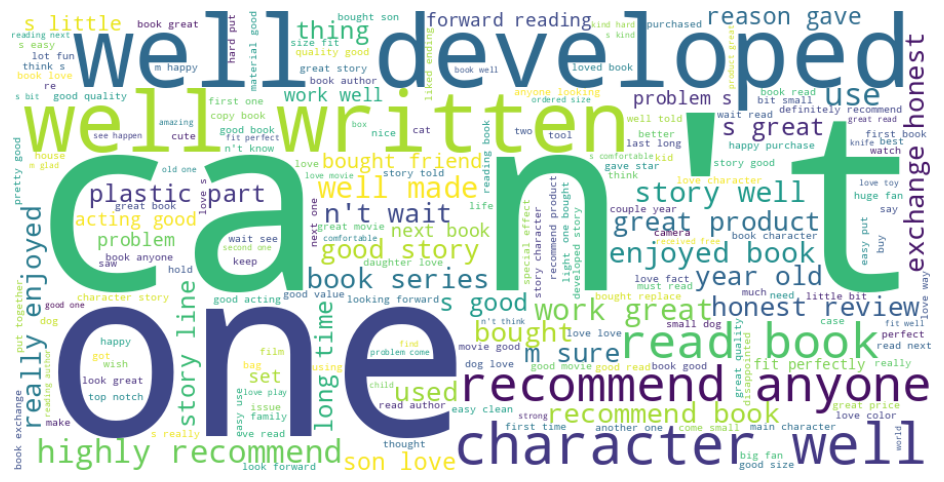

In [92]:
fake_reviews = df[df['label'] == 1]['clean_review']
fake_text = " ".join(fake_reviews)

wordcloud = WordCloud(
    width=900,
    height=450,
    background_color='white'
).generate(fake_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
